# "Gaussian Processes:"
> "description"

- toc: true
- branch: master
- badges: true
- comments: true
- author: Lorenzo Posti
- categories: [gaussian processes, bayesian, jupyter]


## How I got interested in Gaussian Processes

A few weeks ago I saw passing on the arXiv a paper by [Aigrain & Foreman-Mackey](https://arxiv.org/abs/2209.08940) which is a review on Gaussian Processes (GPs) with an astrophysical angle - it is actually targeted for astronomical time-series. I had heard a lot of things about GPs before, but I never really had the time nor will to sit down an actually understand what they are about. That changed when I glanced over the review by Aigrain & Foreman-Mackey, as I quickly realised a couple of things that caught my interest.

In particular, the thing that struck me the most is their Figure 3. This appears at the end of the first Section of the review, of which about half is dedicated to the explanation of two motivating examples from astronomical time-series analysis - a very smart decision to start the review with these two examples I must say.

In [276]:
#collapse-hide
import numpy as np
import matplotlib
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
import jax
import jax.numpy as jnp
import jaxopt
from functools import partial
from tinygp import GaussianProcess, kernels
import numpyro
import arviz
import corner

jax.config.update("jax_enable_x64", True)
import warnings
warnings.filterwarnings('ignore')

%config Completer.use_jedi = False
%matplotlib inline

rng = np.random.default_rng()

Define the mathematical functions for the galaxy rotation curves

In [2]:
G, H, Dc = 4.301e-9, 70, 200.

def jax_fc(x): return jnp.log(1+x)-x/(1+x)
def jax_Vvir(Mh): return jnp.sqrt((Dc*(H)**2/2)**(1./3.) * (G*Mh)**(2./3.))

def jax_Rvir(Mh):
    rho_hat = 4. / 3. * np.pi * Dc * (3. * (H)**2 / (8. * np.pi * G))
    return 1e3 * ((Mh / rho_hat)**(1./3.))

def jax_vhalo(params, R):
    Mh, cc = 10**params['log_mh'], 10**params['log_c']    
    rv = jax_Rvir(Mh)
    return jnp.sqrt(jax_Vvir(Mh)**2*rv/R*jax_fc(cc*R/rv)/jax_fc(cc)) 

### Generating rotation curve data with independent Gaussian noise

Plot a randomly sampled rotation curve with a typical error on each datapoint of 8 km/s

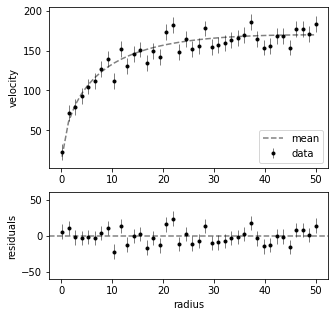

In [243]:
size = 40
lmh, lc, verr = 12, 0.95, 10.0

# generating independent datapoints with Gaussian errors
x = np.linspace(0.1, 50, size)
y = jax_vhalo({'log_mh':lmh, 'log_c':lc}, x) + rng.normal(loc=0, scale=verr, size=size)

fig,ax = plt.subplots(figsize=(5,5), nrows=2, gridspec_kw={'height_ratios':(0.65,0.35)})
# rotation curve
ax[0].plot(x, jax_vhalo({'log_mh':lmh, 'log_c':lc}, x), '--', c='grey', label='mean')
ax[0].errorbar(x, y, yerr=verr, fmt='.', c='k', lw=0.5, label='data')
ax[0].legend(loc='lower right')
ax[0].set_ylabel('velocity');
# residuals
ax[1].axhline(y=0, ls='--', c='grey')
ax[1].errorbar(x, y-jax_vhalo({'log_mh':lmh, 'log_c':lc}, x), yerr=verr, fmt='.', c='k', lw=0.5)
ax[1].set_xlabel('radius')
ax[1].set_ylabel('residuals')
ax[1].set_ylim(-60,60);

In the simple case plotted above we have generated the points with the implicit assumption that each datapoint was independent from all the others. This is why mathematically we simply added a Gaussian noise term to the median curve when defining `y`. In the residuals plot, the fact that each datapoint is independent becomes apparent since there is no clear trend in the residuals as a function of radius.

However, in practice this is rarely the case with astronomical observations, since typically instrumental characteristics of the telescope and physical processes make the measurement of a single datapoint to have a non-negligible dependence on some other datapoints. Most of the times when modelling astrophysical data we do not know precisely if and which measurements are correlated with which others, so it is in our best interest to employ a modelling technique that allows for correlated datapoints, instead of assuming they are independent.
This is where GPs come into play.

### Generating rotation curve data with correlated noise using GPs

Let's now use GPs to generate a new set of datapoints, but this time they will be correlated to one another. To specify this correlation we need to define a `kernel` or a covariance function which, in the simplest case that we are using here, is a function only of the physical distance of each point (absolute or L1 distance). 

Kernels that depend only of the distance of points are called *stationary*. A very common kernel function used in GPs is the so-called *radial basis function* or exponential-squared, since $k(x_i, x_j) \propto \exp\left(d_{ij}^2/2s\right)$, where $d_{ij}=|x_i-x_j|$ is the distance of the two datapoints, while $s\in\mathbb{R}$ is a scale parameter.

We define the GP as follows using the library [tinygp](https://tinygp.readthedocs.io/en/stable/index.html).

In [262]:
def build_gp(params, x, yerr):
    kernel = 10**params['log_amp']*kernels.ExpSquared(10**params['log_scl'], distance=kernels.distance.L1Distance())
    return GaussianProcess(kernel, 
                           x, 
                           diag=yerr**2, 
                           mean=partial(jax_vhalo, params)
                          )

This GP has 2 adjustable parameters: an amplitude `log_amp` and a scale `log_scl` (both defined in log). We build the GP by passing it the kernel function, the set of datapoints (just `x`, not the velocity measurements), the measured uncertainty of the measurements, and the mean function that needs to be added to the noise generated by the GP.

What the library is doing is just building a full covariance matrix on the dataset `x` using the kernel function provided. The value that we pass on the `diag` argument will be considered as an additional variance to be added to the covariance matrix. 

Let's now initialize a GP with some amplitude and scale parameters and let's sample random datapoints from its covariance matrix.

In [263]:
params = {'log_mh':lmh, 'log_c':lc,
          'log_amp':jnp.log10(300.0), 'log_scl':jnp.log10(5.0)}

# initialize the GP and sample from it
gp   = build_gp(params, x, verr)
# vm   = gp.sample(jax.random.PRNGKey(11))
vm   = gp.sample(jax.random.PRNGKey(33))
e_vm = np.sqrt(gp.variance)

Here `gp.sample` gets a random realization of y-measurements on the `x`-array. We can define their standard *errorbars* by just taking the variances (i.e. diagonal of the covariance matrix).

Just to help out with visualising the GP, let's plot the covariance matrix for this problem.

In [269]:
def plt_mat(ax, params, x, yerr):

    gp = build_gp(params, x, yerr)
    
    xm1, xm2 = jnp.meshgrid(x,x)
    zm = np.zeros_like(xm1.flatten())
    for i in range(len(xm1.flatten())):
        zm[i]=(gp.kernel.evaluate(xm1.flatten()[i], xm2.flatten()[i]))
        
    im=ax.matshow(zm.reshape((len(x), len(x))), extent=(x.min(), x.max(), x.max(), x.min()))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)

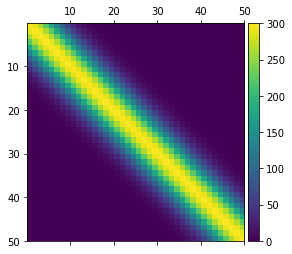

In [272]:
fig,ax = plt.subplots()
plt_mat(ax, params, x, verr)

Here each point is coloured according to the covariance $k(x_i,x_j)$. It is highest along the diagonal, where $k(x_i,x_i)=300$ km$^2$/s$^2$, implying a standard uncertainty on each data point of $\sigma=\sqrt{300+10^2}=20$ km/s, where the term $10^2$ comes from adding the measured uncertainties to the covariance matrix (the `diag` argument in `GaussianProcess`). Given the kernel function and the scale of $5$ that we used in this example, we can see that each datapoint has a significant correlation with all the points closer than ~10.

Finally, let's plot the sampled rotation curve and its residuals and let's compare them with the uncorrelated case above.

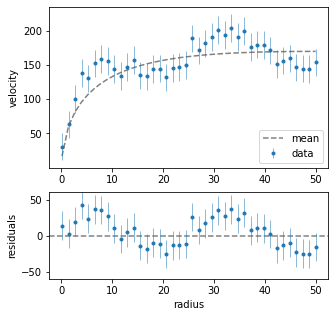

In [264]:
fig,ax = plt.subplots(figsize=(5,5), nrows=2, gridspec_kw={'height_ratios':(0.65,0.35)})
# rotation curve
ax[0].plot(x, jax_vhalo({'log_mh':lmh, 'log_c':lc}, x), '--', c='grey', label='mean')
ax[0].errorbar(x, vm, yerr=e_vm, fmt='.', c='C0', lw=0.5, label='data')
ax[0].legend(loc='lower right')
ax[0].set_ylabel('velocity');
# residuals
ax[1].axhline(y=0, ls='--', c='grey')
ax[1].errorbar(x, vm-jax_vhalo({'log_mh':lmh, 'log_c':lc}, x), yerr=e_vm, fmt='.', c='C0', lw=0.5)
ax[1].set_xlabel('radius')
ax[1].set_ylabel('residuals')
ax[1].set_ylim(-60,60);

We do see quite a lot of structure in the residuals plot this time! This is in stark contrast to the picture we had when generating datapoints independently. This time each measurements *feels* the influence of the other measurements closer than ~10 in radius, thus the rotation curve starts having significant trends above and below the mean.

When fitting the rotation curve these trend can be misinterpreted as signal, instead of just correlated noise, and this can potentially bias our inference on the curve parameters quite significantly. We see below an example of this.

### Fitting the rotation curve with or without Gaussian Processes

Let's now consider the rotation curve generated with the GP above, i.e. the blue set of points, and let's build a model to fit it. The model is the same `jax_vhalo` function that we used to generate the data, which has 2 free parameters: a mass `log_mh` and a concentration `log_c`.

We fit it using a Bayesian framework and in particular with an MCMC sampler using a standard $\chi^2$ log-likelihood on the observed datapoints. We impose a uniform prior on `log_mh` and normal prior on `log_c`, whose mean follows the well-known mass-concentration relation of dark matter halos in $\Lambda$CDM [(Dutton & Maccio' 2014)](https://ui.adsabs.harvard.edu/abs/2014MNRAS.441.3359D/abstract).

In [265]:
# radial grid to define the output of the GP
r_grid = jnp.linspace(0.1, 60.0, 1000)

def model(t, y_err, y, use_gp=False):
    
    # priors
    log_mh = numpyro.sample('log_mh', numpyro.distributions.Uniform(8.0,  14.0)) 
    log_c  = numpyro.sample('log_c',  numpyro.distributions.Normal(0.905-0.101*(log_mh-12.0), 0.15)) 
    
    # parameters to infer
    params = {
        "log_mh": log_mh,
        "log_c" : log_c, 
    }
    
    if use_gp:
        params["log_amp"] = numpyro.sample("log_amp", numpyro.distributions.Normal(1.0, 3.0))
        params["log_scl"] = numpyro.sample("log_scl", numpyro.distributions.Normal(0.5, 2.0))
        gp = build_gp(params, t, y_err)
        numpyro.sample("y", gp.numpyro_dist(), obs=y)
        mu = gp.mean_function(r_grid)
        numpyro.deterministic("mu", mu)
        numpyro.deterministic("gp", gp.condition(y, r_grid, include_mean=False).gp.loc)

    else:
        numpyro.sample("y", numpyro.distributions.Normal(jax_vhalo(params, t), y_err), obs=y)
        numpyro.deterministic("mu", jax_vhalo(params, r_grid))

In [266]:
sampler_wn = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        model,
        dense_mass=True,
        target_accept_prob=0.9,
        init_strategy=numpyro.infer.init_to_value(values={'log_mh':11.0, 'log_c':1.0}),
    ),
    num_warmup=1000,
    num_samples=3000,
    num_chains=2,
    progress_bar=True,
)
%time sampler_wn.run(jax.random.PRNGKey(11), x, e_vm, vm)

inf_data_wn = arviz.from_numpyro(sampler_wn)
arviz.summary(inf_data_wn, var_names=["log_mh", "log_c"])

sample: 100%|████████████████████████████████████████████████████████████████████| 4000/4000 [00:05<00:00, 700.79it/s, 3 steps of size 7.96e-01. acc. prob=0.93]


CPU times: user 15.2 s, sys: 282 ms, total: 15.5 s
Wall time: 16.1 s


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_mh,11.897,0.060,11.786,12.009,0.001,0.001,4581.0,3535.0,1.0
log_c,1.087,0.058,0.983,1.200,0.001,0.001,4758.0,3911.0,1.0


In [267]:
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        model,
        dense_mass=True,
        target_accept_prob=0.9,
        init_strategy=numpyro.infer.init_to_value(values={'log_mh':11.0, 'log_c':1.0, 
                                                          'log_amp':1.0, 'log_scl':0.5
                                                         }),
    ),
    num_warmup=1000,
    num_samples=3000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(11), x, e_vm, vm, use_gp=True)

inf_data = arviz.from_numpyro(sampler)
arviz.summary(inf_data, var_names=["log_mh", "log_c", "log_amp", "log_scl"])

sample: 100%|███████████████████████████████████████████████████████████████████| 4000/4000 [00:10<00:00, 392.12it/s, 15 steps of size 2.34e-01. acc. prob=0.97]


CPU times: user 54.2 s, sys: 948 ms, total: 55.1 s
Wall time: 32.2 s


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_mh,11.966,0.222,11.593,12.428,0.006,0.004,1825.0,1669.0,1.0
log_c,0.993,0.136,0.742,1.258,0.003,0.002,1885.0,2479.0,1.0
log_amp,2.698,0.525,1.945,3.593,0.023,0.016,1418.0,949.0,1.0
log_scl,0.822,0.244,0.540,1.126,0.009,0.007,2107.0,1848.0,1.0


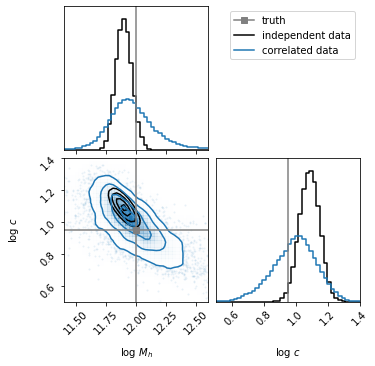

In [283]:
ranges = [(11.4, 12.6), (0.5, 1.4)] # PRNG 33
fig = corner.corner(inf_data_wn, bins=40, range=ranges, 
                    color="k", var_names=["log_mh", "log_c"], smooth=1.0, smooth1d=1.0
                   )
fig = corner.corner(inf_data, bins=40, range=ranges, 
                    color="C0", var_names=["log_mh", "log_c"], smooth=1.0, smooth1d=1.0,
                    labels=["$\log\,M_h$", "$\log\,c$"],
                    truths=[params['log_mh'], params['log_c']], truth_color='grey',
                    fig=fig)

ax = fig.axes[1]
key_tr = matplotlib.lines.Line2D([], [], color='grey', linestyle='-', marker='s', label='truth')
key_nn = matplotlib.lines.Line2D([], [], color='k',    linestyle='-', label='independent data')
key_gp = matplotlib.lines.Line2D([], [], color='C0',   linestyle='-', label='correlated data')
ax.legend(loc='upper right', handles=[key_tr, key_nn, key_gp])


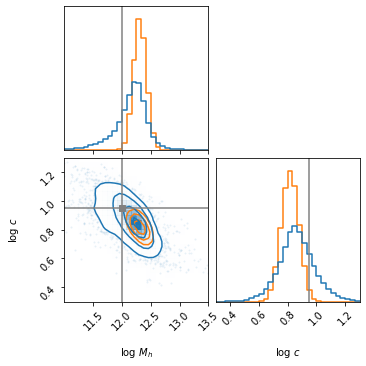

In [121]:
ranges = [(11, 13.5), (0.3, 1.3)] # PRNG 27
fig = corner.corner(inf_data_wn, bins=30, range=ranges, 
                    color="C1", var_names=["log_mh", "log_c"], smooth=1.0, smooth1d=1.0
                   )
fig = corner.corner(inf_data, bins=30, range=ranges, 
                    color="C0", var_names=["log_mh", "log_c"], smooth=1.0, smooth1d=1.0,
                    labels=["$\log\,M_h$", "$\log\,c$"],
                    truths=[params['log_mh'], params['log_c']], truth_color='grey',
                    fig=fig)